[*********************100%***********************]  1 of 1 completed
                 High        Low       Open      Close
Date                                                  
2020-01-02  75.150002  73.797501  74.059998  75.087502
2020-01-03  75.144997  74.125000  74.287498  74.357498
2020-01-06  74.989998  73.187500  73.447502  74.949997
2020-01-07  75.224998  74.370003  74.959999  74.597504
2020-01-08  76.110001  74.290001  74.290001  75.797501
[*********************100%***********************]  1 of 1 completed
Total return of SMA Crossover Strategy: 125.27%


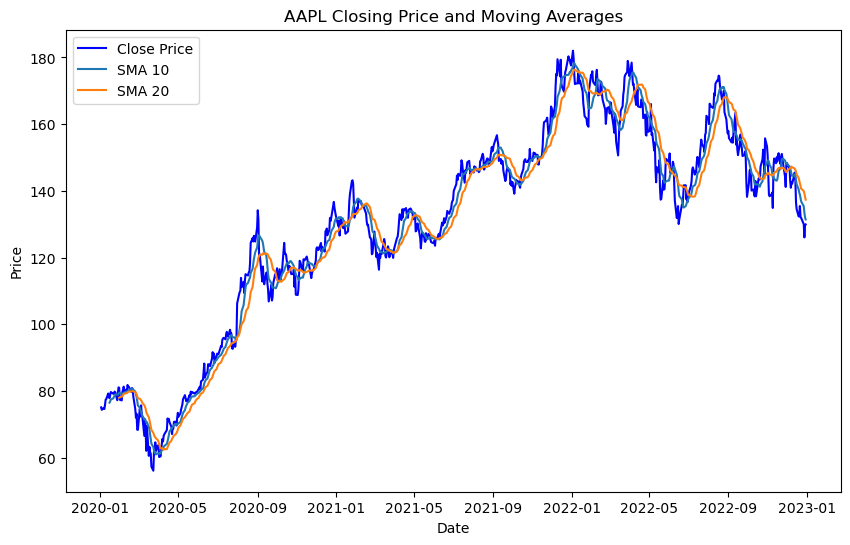

In [17]:
#import streamlit as st
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

#1. Price Data

# User input using Streamlit components
#selected_ticker = st.selectbox("Select a stock ticker from the list:", Nasdaq_NYSE_10)
selected_ticker = "AAPL"
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch historical price data using yfinance
stock_data = yf.download(selected_ticker, start=start_date, end=end_date)

# Create a DataFrame with selected price data
stock_df = pd.DataFrame()
stock_df['High'] = stock_data['High']
stock_df['Low'] = stock_data['Low']
stock_df['Open'] = stock_data['Open']
stock_df['Close'] = stock_data['Close']

print(stock_df.head())

#-------------------------------------------------------------

#2. Technical Indicators: Moving Averages
def calculate_sma(stock_data, window):
    return stock_data['Close'].rolling(window=window).mean()

# Streamlit
# st.title("Stock Technical Indicators")
# selected_ticker = st.text_input("Enter Ticker Symbol:", "AAPL")
# start_date = st.date_input("Start Date", pd.to_datetime('2020-01-01'))
# end_date = st.date_input("End Date", pd.to_datetime('2021-01-01'))

# User input for Simple Moving Average
# show_sma = st.checkbox("Show Simple Moving Average")

# Fetch data
stock_data = yf.download(selected_ticker, start=start_date, end=end_date)
short_window = 10
long_window = 20

# Calculate and plot indicators
# if show_sma:
#     st.write("Enter window values for moving averages:")
    
# short_window = st.number_input("Short Window", value=10)
# long_window = st.number_input("Long Window", value=50)

# st.write(f"You've chosen short window: {short_window} and long window: {long_window}")
        
# Calculate moving averages
moving_averages = []
short_window = int(short_window)
long_window = int(long_window)

if short_window > 0 and long_window > 0:
        ma_short = calculate_sma(stock_data, short_window)
        ma_long = calculate_sma(stock_data, long_window)
        moving_averages.append((f'SMA {short_window}', ma_short))
        moving_averages.append((f'SMA {long_window}', ma_long))

# Plot indicators
plt.figure(figsize=(10,6))
plt.plot(stock_data['Close'], label='Close Price', color='blue')

for label, ma in moving_averages:
    plt.plot(ma, label=label)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{selected_ticker} Closing Price and Moving Averages")
plt.legend()

# -------------------------------------------------------------
# Backtest Strategy

# User input for Simple Moving Average
# show_sma = st.checkbox("Backtest your SMA strategy")    
 
# Functions for calculations

def backtest_crossover_strategy(stock_df, short_window, long_window):
    short_sma = calculate_sma(stock_df, short_window)
    long_sma = calculate_sma(stock_df, long_window)

    # Buy signal: when short EMA crosses above long EMA
    stock_df['Buy Signal'] = (short_sma > long_sma) & (short_sma.shift(1) <= long_sma.shift(1))

    # Sell signal: when short EMA crosses below long EMA
    stock_df['Sell Signal'] = (short_sma < long_sma) & (short_sma.shift(1) >= long_sma.shift(1))

    # Assume starting with cash, so the first signal should be a buy
    initial_position = "cash"
    positions = [initial_position]

    for i in range(1, len(stock_df)):
        if stock_df['Buy Signal'].iloc[i]:
            positions.append("stock")
        elif stock_df['Sell Signal'].iloc[i]:
            positions.append("cash")
        else:
            positions.append(positions[-1])

    stock_df['Position'] = positions
    
    # Calculate returns
    stock_df['Daily Strategy Return'] = np.where(stock_df['Position'] == "stock", stock_df['Close'].pct_change(), 0)
    total_strategy_return = (stock_df['Daily Strategy Return'] + 1).prod()
    return total_strategy_return
    

# test strategy    
short_window = 10
long_window = 20

total_strategy_return = backtest_crossover_strategy(stock_df, short_window, long_window)
stock_df.to_csv('sma_crossover.csv', index=False)
total_strategy_return = 100*(total_strategy_return-1)
print(f"Total return of SMA Crossover Strategy: {total_strategy_return:.2f}%")
    